In [1]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import numpy as np

import swifter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler
from numpy import linalg as LA
import warnings
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram

# Reading Data and performing required EDA

In [2]:

df_data= pd.read_csv('TCGA-PANCAN-HiSeq-801x20531/data.csv')
df_data.drop(columns=['Unnamed: 0'],inplace=True)


# Hierarchical Clustering using method- complete  and cutting at required distance to get number of clusters

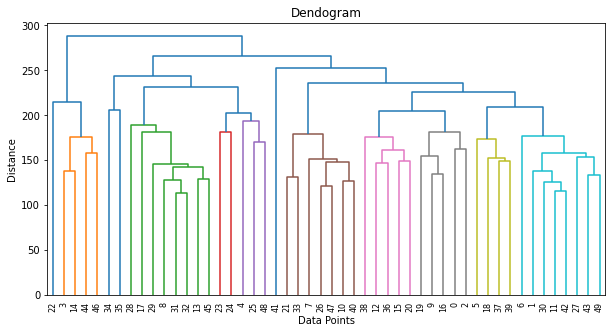

Number of clusters:5
Cluster sizes: [5, 2, 13, 29, 1]


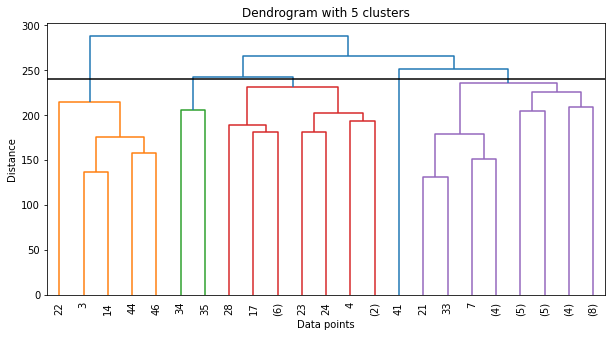

In [35]:
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster
def hierarchical_clustering(data):
    # Standardize the data to ensure all features have the same scale
    data_scaled = StandardScaler().fit_transform(data)

    # Perform hierarchical clustering with full linkage
    Z = linkage(data_scaled, method='complete')

    # Plot dendrogram
    plt.figure(figsize=(10,5))
    dendrogram(Z)
    plt.ylabel('Distance')
    plt.xlabel('Data Points')
    plt.title('Dendogram')
    plt.show()
    
    return Z,data_scaled


def cut_dendogram(Z,k,max_d):
    distance_threshold = Z[-k, 2]
    clusters = fcluster(Z, distance_threshold, criterion='distance')

    # Print the number of clusters and their sizes
    n_clusters = len(np.unique(clusters))
    cluster_sizes = [np.sum(clusters == i) for i in range(1, n_clusters+1)]
    print('Number of clusters:{}'.format(n_clusters))
    print('Cluster sizes: {}'.format(cluster_sizes))

    # Plot dendrogram with cluster labels
    plt.figure(figsize=(10, 5))
    dendrogram(Z, truncate_mode='level', p=5, color_threshold=max_d)
    plt.title('Dendrogram with {} clusters'.format(n_clusters))
    plt.xlabel('Data points')
    plt.ylabel('Distance')
    plt.xticks(rotation=90)
    plt.axhline(y=max_d, c='k')
    plt.show()
    return clusters

# Randomly select 50 data points from the dataset
df_50 = df_data.sample(n=50, random_state=42)
Z,data_scaled=hierarchical_clustering(df_50)
clusters=cut_dendogram(Z,5,240)

# Calcualting Error Rate

In [8]:
def new_centroids(df_label, df1):
    df1['Label']=df_label
    # Calculate the mean of the rows with the same label
    return df1.groupby('Label').mean() # Transpose the dataframe to have the new centroids as columns and index as feature name


def sum_of_square_error(new_centroids, data, labels):
    """
    Computes the sum of squared errors between the data points and their assigned centroids.

    Args:
    new_centroids (DataFrame): The new centroids computed in the current iteration.
    data (DataFrame): The input data points.
    labels : The labels assigned to each data point.

    Returns:
    The sum of squared errors.
    """
    # Transpose the new centroids dataframe and reset the index
    new_centroids = new_centroids.reset_index()
    # Get the columns of the data dataframe
    columns = data.columns
    # Join the data dataframe and the labels clusters
    data['Label'] = labels
    sse = []
    # Compute the distance between each data point and its assigned centroid
    for i in range(1,len(new_centroids)):
        distance = np.sum(np.square(data[data['Label']==i][columns] - new_centroids.iloc[i][columns]), axis=1)
        sse.append(sum(distance))
    # Return the sum of squared errors
    return sum(sse)   


In [9]:

df_50_scaled= pd.DataFrame(data_scaled)
df_50_scaled.columns= df_data.columns



In [10]:
df_new_centroids = new_centroids(clusters, df_50_scaled)
sse=sum_of_square_error(df_new_centroids, df_50_scaled, clusters)
print('The within cluster sum of square error rate is {}'.format(sse))

The within cluster sum of square error rate is 2139434.5118071763


# Performing PCA

In [11]:
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler
from numpy import linalg as LA
import warnings




def PCA(df,threshold):
    ## Performing Standardization so that all features are given same importance initially and each feature can contribute
    ## equally to PC irrespective of scale or magnitude
    df =pd.DataFrame(StandardScaler().fit_transform(df))
    ## Performing Data Centering on standardized dataframe
    centred_df= df-np.mean(df,axis=0)
    ## Calculating Covariance 
    covariance=np.cov(df.T)
    eigen_values, eigen_vectors = LA.eig(covariance)
    ## Sorting the eigen values in descending order, using argsort, we get the indices of eigen values in descending order
    sorted_index=eigen_values.argsort()[::-1]
    df_variance=pd.DataFrame(eigen_values[sorted_index]/sum(eigen_values),columns=['variance'])
    df_variance['cumulative_variance']= df_variance['variance'].cumsum()
    ## Number of principal components required to cover variance uptill certian threshold
    df_number_pc_var=df_variance[df_variance['cumulative_variance']<= threshold]
    number_of_pc=len(df_number_pc_var)
    print("The number of principal components required to cover {} percent variance are {}".format(threshold*100,number_of_pc))
    ## Selecting the required number of eigen vectores for performing dot product
    selected_eigen_vectors=eigen_vectors[:,sorted_index[:number_of_pc]]
    
    #Projecting data over the selected number of principal components
    principal_component=centred_df.dot(selected_eigen_vectors) #Performing dot product
    principal_component.columns=[f'PC{i+1}' for i in range(number_of_pc)]
    ## Creating Scree plots
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot the first subplot of variance on the left side
    axes[0].plot(range(1,len(df_number_pc_var)+1), df_number_pc_var['variance'],'ro-', linewidth=2)
    axes[0].set_title('Scree Plot for Variance')
    axes[0].set_ylabel('Variance')
    axes[0].set_xlabel('Number of Principal Component')
    axes[0].set_xticks(np.arange(1, len(df_number_pc_var)+1, 1),rotation=90)

    # Plot the second subplot of cumulative variance on the right side
    axes[1].plot(range(1,len(df_number_pc_var)+1), df_number_pc_var['cumulative_variance'],'ro-', linewidth=2)
    axes[1].set_title('Scree Plot for Cumulative Variance')
    axes[1].set_ylabel('Cumulative Variance')
    axes[1].set_xlabel('Number of Principal Component')
    axes[1].set_xticks(np.arange(1, len(df_number_pc_var)+1, 1),rotation=90)
    plt.show()
    print('Correlation of PC1,PC2 \n',principal_component[['PC1','PC2']].corr())
    plt.scatter(principal_component['PC1'],principal_component['PC2'])
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Scatter plot of PC1 VS PC2')
    plt.show()
    print('The Total variance explained by PC1,PC2 is {} percent'.format(round(np.real(df_number_pc_var['cumulative_variance'][1])*100,2)))
    
    loadings = pd.DataFrame(selected_eigen_vectors,index=df.columns)
    warnings.filterwarnings("ignore")
    
    return principal_component,loadings,df_variance

The number of principal components required to cover 90.0 percent variance are 34


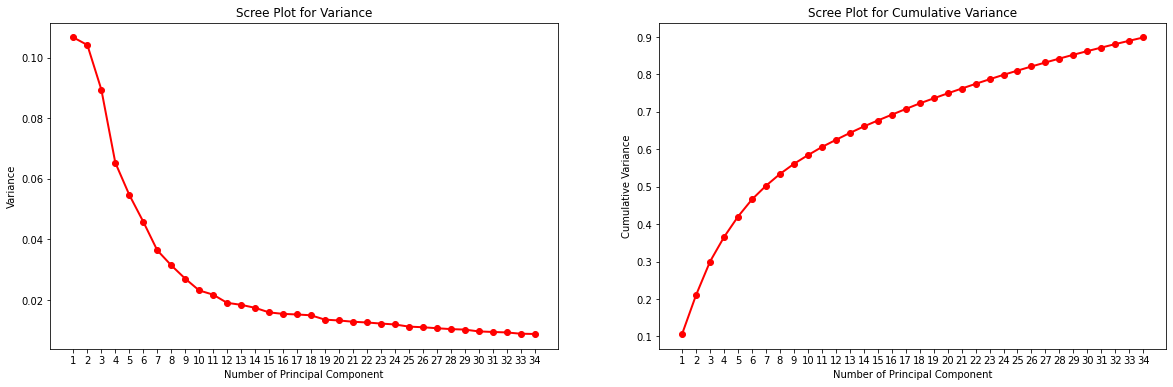

Correlation of PC1,PC2 
               PC1           PC2
PC1  1.000000e+00 -1.842486e-16
PC2 -1.842486e-16  1.000000e+00


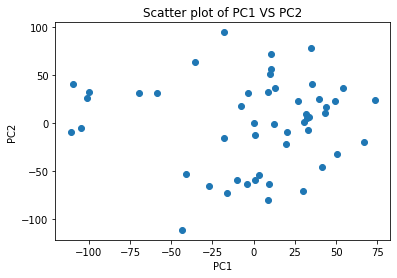

The Total variance explained by PC1,PC2 is 21.08 percent


In [15]:
principal_component,loadings,df_variance=PCA(df_50,0.9)


In [16]:
principal_component

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34
0,-7.5672780+0.0000000j,18.393907+0.000000j,3.9427780+0.0000000j,33.707479+0.000000j,-42.191383+0.000000j,36.228898+0.000000j,62.904103+0.000000j,-17.930336+0.000000j,-3.697477+0.000000j,-46.394547+0.000000j,...,-11.793848+0.000000j,-8.272443+0.000000j,9.056614+0.000000j,-9.343413+0.000000j,-11.707870+0.000000j,22.788154+0.000000j,24.320696+0.000000j,-8.470749+0.000000j,-19.604875+0.000000j,5.736149+0.000000j
1,27.108331+0.000000j,22.813466+0.000000j,-38.892590+0.000000j,-19.735368+0.000000j,3.676627+0.000000j,26.530036+0.000000j,-20.469555+0.000000j,0.068026+0.000000j,20.050289+0.000000j,-9.003743+0.000000j,...,39.988657+0.000000j,-9.796850+0.000000j,-14.827603+0.000000j,-4.735848+0.000000j,-42.262323+0.000000j,2.193865+0.000000j,-2.745526+0.000000j,-35.686104+0.000000j,-29.252686+0.000000j,24.221901+0.000000j
2,20.247553+0.000000j,-9.4940280+0.0000000j,34.448929+0.000000j,19.122205+0.000000j,-50.907429+0.000000j,32.009603+0.000000j,47.797472+0.000000j,14.830222+0.000000j,-22.403179+0.000000j,-9.476861+0.000000j,...,20.395650+0.000000j,-11.942996+0.000000j,-8.483028+0.000000j,-13.864709+0.000000j,8.905047+0.000000j,-16.275778+0.000000j,-23.493845+0.000000j,21.026340+0.000000j,-1.655413+0.000000j,-19.830781+0.000000j
3,73.568038+0.000000j,23.976773+0.000000j,44.449164+0.000000j,38.850811+0.000000j,61.160205+0.000000j,8.4364490+0.0000000j,-3.054892+0.000000j,-17.895930+0.000000j,-7.414737+0.000000j,-4.049222+0.000000j,...,15.290536+0.000000j,19.477022+0.000000j,-0.908989+0.000000j,-12.968091+0.000000j,-6.571192+0.000000j,6.520342+0.000000j,-8.270914+0.000000j,-1.982940+0.000000j,-16.624232+0.000000j,-13.983627+0.000000j
4,33.215886+0.000000j,-7.3707100+0.0000000j,-11.915745+0.000000j,-7.2193480+0.0000000j,-4.011522+0.000000j,-27.429169+0.000000j,-44.136003+0.000000j,-5.673496+0.000000j,68.950758+0.000000j,2.132878+0.000000j,...,2.727325+0.000000j,15.298543+0.000000j,17.653843+0.000000j,-14.885827+0.000000j,-4.748556+0.000000j,-0.893356+0.000000j,1.942322+0.000000j,-18.931377+0.000000j,-0.262270+0.000000j,-15.034584+0.000000j
5,-18.000191+0.000000j,94.916477+0.000000j,-25.812498+0.000000j,-15.784252+0.000000j,18.287420+0.000000j,-49.066401+0.000000j,30.698967+0.000000j,15.275471+0.000000j,-46.264227+0.000000j,6.914369+0.000000j,...,12.177130+0.000000j,-9.118455+0.000000j,-12.862948+0.000000j,-25.263965+0.000000j,8.053269+0.000000j,-2.478228+0.000000j,10.849428+0.000000j,4.803040+0.000000j,-5.467431+0.000000j,3.363845+0.000000j
6,10.738309+0.000000j,56.761240+0.000000j,-50.807229+0.000000j,-29.634474+0.000000j,31.461801+0.000000j,3.4685640+0.0000000j,17.848011+0.000000j,-13.928707+0.000000j,14.904695+0.000000j,-5.930071+0.000000j,...,-10.649827+0.000000j,19.095970+0.000000j,-2.779525+0.000000j,-2.062478+0.000000j,-2.877992+0.000000j,-1.139217+0.000000j,5.899478+0.000000j,4.448015+0.000000j,7.368174+0.000000j,-3.264859+0.000000j
7,-101.020806+0.000000j,26.282291+0.000000j,42.306926+0.000000j,20.947016+0.000000j,13.005663+0.000000j,13.370021+0.000000j,-26.533338+0.000000j,-3.947955+0.000000j,-2.122045+0.000000j,-9.325205+0.000000j,...,15.752077+0.000000j,-17.270387+0.000000j,33.487823+0.000000j,9.281031+0.000000j,22.244759+0.000000j,45.018435+0.000000j,6.255698+0.000000j,-8.541198+0.000000j,8.360748+0.000000j,-4.041117+0.000000j
8,9.3220950+0.0000000j,-62.894899+0.000000j,-20.761493+0.000000j,31.936580+0.000000j,-8.485603+0.000000j,-17.343438+0.000000j,-3.260969+0.000000j,54.947082+0.000000j,9.699993+0.000000j,-4.783349+0.000000j,...,11.270003+0.000000j,-4.160920+0.000000j,-12.270055+0.000000j,-3.538253+0.000000j,4.264797+0.000000j,5.438961+0.000000j,-6.291676+0.000000j,3.439669+0.000000j,8.115683+0.000000j,-1.083122+0.000000j
9,54.177865+0.000000j,37.200980+0.000000j,0.2261870+0.0000000j,49.348818+0.000000j,-18.044327+0.000000j,31.678802+0.000000j,29.037744+0.000000j,-1.999304+0.000000j,-4.508640+0.000000j,16.395713+0.000000j,...,-2.187

In [18]:
df_kmeans1= pd.DataFrame(np.real(principal_component.values), columns=principal_component.columns)

# Hierarchical Clustering after PCA

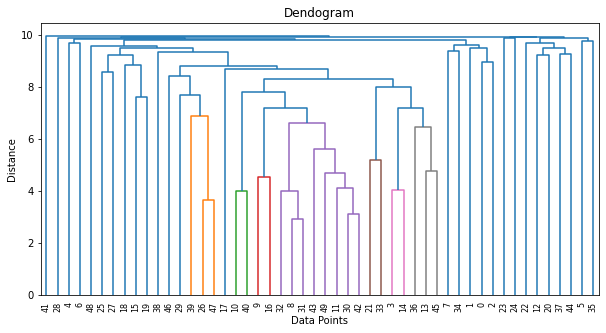

In [37]:
Z,data_scaled=hierarchical_clustering(df_kmeans1)


Number of clusters:5
Cluster sizes: [40, 2, 5, 2, 1]


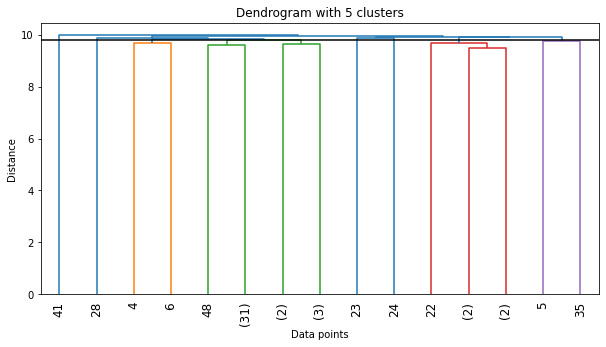

In [38]:
clusters=cut_dendogram(Z,5,9.8)

In [39]:

df_50_scaled= pd.DataFrame(df_kmeans1)
df_50_scaled.columns= df_kmeans1.columns
df_new_centroids = new_centroids(clusters, df_50_scaled)
sse=sum_of_square_error(df_new_centroids, df_50_scaled, clusters)
print('The within cluster sum of square error rate is {}'.format(sse))


The within cluster sum of square error rate is 1611959.1275101865


# The error rate reduced after applying PCA over the data

In [ ]:
# df_kmeans1= pd.DataFrame(np.real(principal_component.values), columns=principal_component.columns)
# df_kmeans1.to_csv('principal_component_50data.csv',indesx=False)